In [15]:
#Data can be found @ https://finance.yahoo.com/quote/MSFT/history

In [16]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Data Science WorkSpace/Data Science Projects/Stock Price Prediction with LSTM/MSFT.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-12-03,0.170139,0.171875,0.168403,0.168837,0.105601,35164800
1,1986-12-04,0.168837,0.172743,0.167535,0.171007,0.106958,42508800
2,1986-12-05,0.171007,0.171875,0.170139,0.170139,0.106415,107510400
3,1986-12-08,0.170139,0.171875,0.165799,0.168403,0.105330,22665600
4,1986-12-09,0.168403,0.169271,0.166667,0.167535,0.104787,16099200


In [17]:
import datetime 

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1983-03-19')
datetime_object

datetime.datetime(1983, 3, 19, 0, 0)

In [18]:
df = df[['Date', 'Close']]
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0      1986-12-03
1      1986-12-04
2      1986-12-05
3      1986-12-08
4      1986-12-09
          ...    
9059   2022-11-11
9060   2022-11-14
9061   2022-11-15
9062   2022-11-16
9063   2022-11-17
Name: Date, Length: 9064, dtype: datetime64[ns]

In [19]:
df.index = df.pop('Date')
df

,Close
Date,
1986-12-03,0.168837
1986-12-04,0.171007
1986-12-05,0.170139
1986-12-08,0.168403
1986-12-09,0.167535
...,...
2022-11-11,247.110001
2022-11-14,241.550003
2022-11-15,241.970001


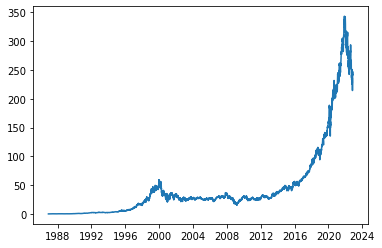

In [20]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [21]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year,month,day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time=True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0,n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

# Start day second time around: '2021-11-19'
windowed_df = df_to_windowed_df(df,
                                '1986-12-08',
                                '2022-11-17',
                                n=3)

windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1986-12-08,0.168837,0.171007,0.170139,0.168403
1,1986-12-09,0.171007,0.170139,0.168403,0.167535
2,1986-12-10,0.170139,0.168403,0.167535,0.168837
3,1986-12-11,0.168403,0.167535,0.168837,0.170139
4,1986-12-12,0.167535,0.168837,0.170139,0.164063
...,...,...,...,...,...
9056,2022-11-11,228.869995,224.509995,242.979996,247.110001
9057,2022-11-14,224.509995,242.979996,247.110001,241.550003
9058,2022-11-15,242.979996,247.110001,241.550003,241.970001
9059,2022-11-16,247.110001,241.550003,241.970001,241.729996


In [23]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, 1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((9061,), (9061, 3, 1), (9061,))

In [24]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

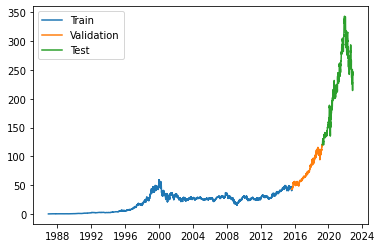

In [25]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [27]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer = Adam(learning_rate=0.001),
              metrics= ['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
227/227 [==============================] - 5s 9ms/step - loss: 76.4246 - mean_absolute_error: 3.8900 - val_loss: 964.6490 - val_mean_absolute_error: 23.0590
Epoch 2/100
227/227 [==============================] - 1s 4ms/step - loss: 0.4618 - mean_absolute_error: 0.4076 - val_loss: 850.4571 - val_mean_absolute_error: 21.2035
Epoch 3/100
227/227 [==============================] - 1s 4ms/step - loss: 0.3595 - mean_absolute_error: 0.3571 - val_loss: 785.5226 - val_mean_absolute_error: 20.0315
Epoch 4/100
227/227 [==============================] - 1s 4ms/step - loss: 0.2970 - mean_absolute_error: 0.3313 - val_loss: 736.7096 - val_mean_absolute_error: 19.1079
Epoch 5/100
227/227 [==============================] - 1s 4ms/step - loss: 0.2405 - mean_absolute_error: 0.3030 - val_loss: 709.0757 - val_mean_absolute_error: 18.4860
Epoch 6/100
227/227 [==============================] - 1s 4ms/step - loss: 0.1767 - mean_absolute_error: 0.2529 - val_loss: 653.2925 - val_mean_absolute_error:

227/227 [==============================] - 2s 6ms/step


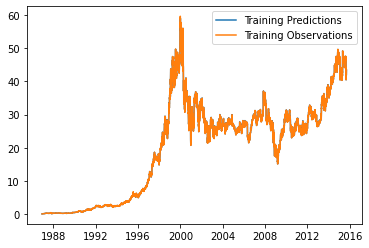

In [28]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

29/29 [==============================] - 0s 2ms/step


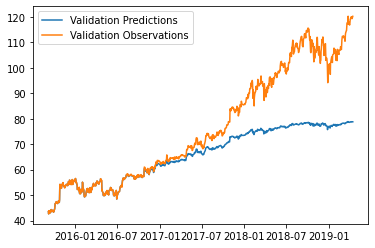

In [29]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

29/29 [==============================] - 0s 2ms/step


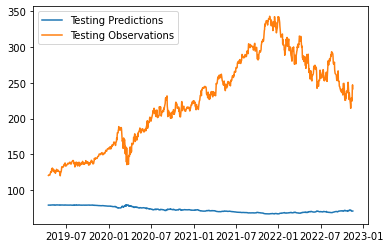

In [30]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

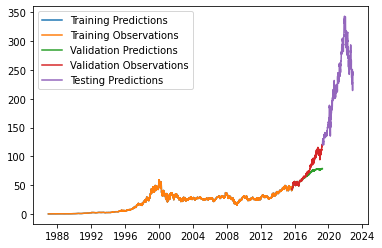

In [31]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend([
    'Training Predictions',
    'Training Observations',
    'Validation Predictions',
    'Validation Observations',
    'Testing Predictions',
    'Testing Observations'
])

### Running the same code above but with smaller time frame

In [33]:
windowed_df2 = df_to_windowed_df(df,
                                '2021-11-17',
                                '2022-11-17',
                                n=3)
windowed_df2

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-11-17,336.720001,336.070007,339.510010,339.119995
1,2021-11-18,336.070007,339.510010,339.119995,341.269989
2,2021-11-19,339.510010,339.119995,341.269989,343.109985
3,2021-11-22,339.119995,341.269989,343.109985,339.829987
4,2021-11-23,341.269989,343.109985,339.829987,337.679993
...,...,...,...,...,...
248,2022-11-11,228.869995,224.509995,242.979996,247.110001
249,2022-11-14,224.509995,242.979996,247.110001,241.550003
250,2022-11-15,242.979996,247.110001,241.550003,241.970001
251,2022-11-16,247.110001,241.550003,241.970001,241.729996


In [34]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, 1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df2)

dates.shape, X.shape, y.shape

((253,), (253, 3, 1), (253,))

In [35]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

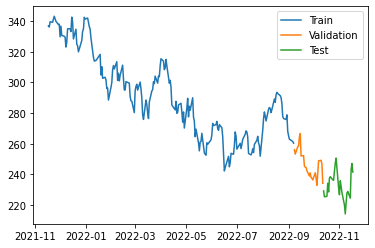

In [36]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [37]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer = Adam(learning_rate=0.001),
              metrics= ['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 107ms/step - loss: 85420.0625 - mean_absolute_error: 291.0479 - val_loss: 60605.8516 - val_mean_absolute_error: 246.0145
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 85106.1797 - mean_absolute_error: 290.5069 - val_loss: 60367.9219 - val_mean_absolute_error: 245.5304
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 84788.8906 - mean_absolute_error: 289.9590 - val_loss: 60036.0664 - val_mean_absolute_error: 244.8537
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 84350.6719 - mean_absolute_error: 289.2047 - val_loss: 59599.6367 - val_mean_absolute_error: 243.9608
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 83762.1562 - mean_absolute_error: 288.1854 - val_loss: 58977.4414 - val_mean_absolute_error: 242.6823
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 82911.7422 - mean_absolute_error: 286.7036 - val_loss: 58070.

7/7 [==============================] - 1s 4ms/step


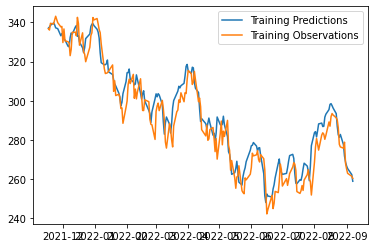

In [38]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 23ms/step


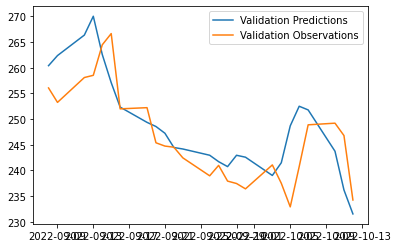

In [39]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 57ms/step


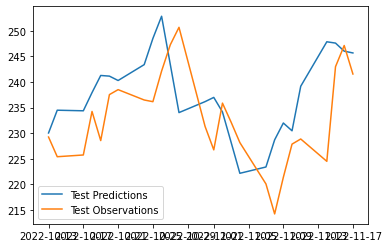

In [40]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])

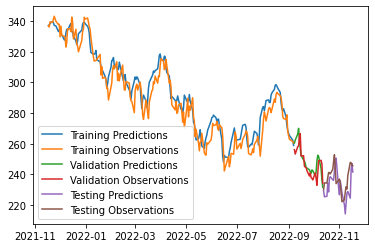

In [49]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.plot(dates_test, test_predictions)
plt.legend([
    'Training Predictions',
    'Training Observations',
    'Validation Predictions',
    'Validation Observations',
    'Testing Predictions',
    'Testing Observations'
])

In [43]:
from copy import deepcopy 

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

In [46]:
for target_date in recursive_dates:
    last_window = deepcopy(X_train[-1])
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[-1] = next_prediction

1/1 [==============================] - 0s 20ms/step


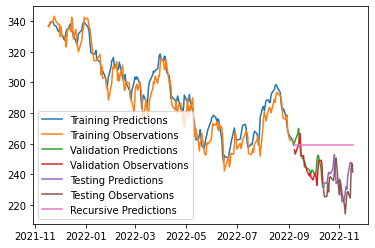

In [50]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend([
    'Training Predictions',
    'Training Observations',
    'Validation Predictions',
    'Validation Observations',
    'Testing Predictions',
    'Testing Observations',
    'Recursive Predictions'
])